<img src="https://cdn.discordapp.com/attachments/1111599839663370271/1125364167927418950/Fake-news-banner.jpg">

# **Fake News Classifier using Bidirectional LSTM**

---

In [38]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import datetime
import warnings
import nltk
import random
import re
import sklearn
import zipfile
import gensim
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt',download_dir="/kaggle/working/")
nltk.download('wordnet',download_dir="/kaggle/working/")
nltk.download('stopwords',download_dir="/kaggle/working/")
nltk.data.path.append('/kaggle/working/')

with zipfile.ZipFile("/kaggle/working/corpora/wordnet.zip", 'r') as zip_f:
    zip_f.extractall("/kaggle/working/corpora/")
    
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
%matplotlib inline
plt.style.use('dark_background')

[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Package stopwords is already up-to-date!


# Importing Dataset

In [39]:
news_data = pd.read_csv("/kaggle/input/fake-news/FakeNewsNet.csv")
news_data.dropna(inplace=True)
news_data.reset_index(inplace=True)
news_data.drop(["index","news_url","source_domain","tweet_num"],axis=1,inplace=True)
news_data.head()

,title,real
0,Kandi Burruss Explodes Over Rape Accusation on...,1
1,People's Choice Awards 2018: The best red carp...,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,1
3,Colombian singer Maluma sparks rumours of inap...,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,1


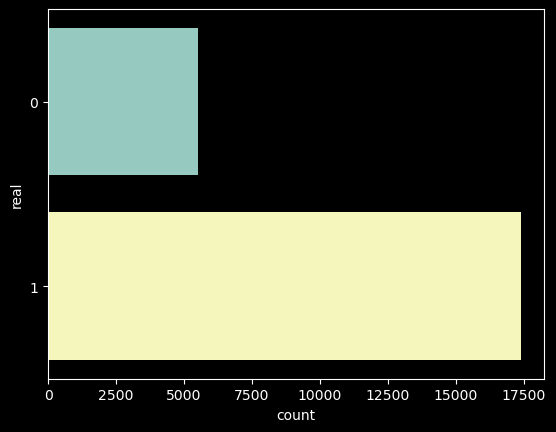

In [40]:
sns.countplot(data = news_data,y="real");

# Text Preprocessing

In [41]:
stopwords = nltk.corpus.stopwords.words("english")

In [42]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemTitles(title):
    words = nltk.word_tokenize(title)
    words = [re.sub("[^a-zA-Z0-9]","",i).lower().strip() for i in words]
    words = [lemmatizer.lemmatize(i) for i in words if i not in stopwords]
    title = " ".join(words)
    return title

news_data["title"] = news_data["title"].apply(lemTitles)
news_data.head()

,title,real
0,kandi burruss explodes rape accusation real ho...,1
1,people choice award 2018 best red carpet look,1
2,sophia bush sends sweet birthday message one t...,1
3,colombian singer maluma spark rumour inappropr...,1
4,gossip girl 10 year later upper east siders s...,1


In [43]:
VOCAB_SIZE = 10000
DIMENSION = 100
MAXLEN = 20

In [44]:
def oneHot(title):
    return tf.keras.preprocessing.text.one_hot(title,VOCAB_SIZE)

news_data["title"] = news_data["title"].apply(oneHot)

In [45]:
news_data.head()

,title,real
0,"[5641, 7391, 7567, 3802, 7731, 1378, 6165, 393...",1
1,"[732, 6816, 1451, 8622, 8561, 7021, 4867, 673]",1
2,"[8051, 4621, 2132, 5935, 1786, 5323, 9982, 943...",1
3,"[5560, 8001, 565, 7741, 7292, 9549, 5090, 6002]",1
4,"[5383, 1234, 4817, 1407, 3047, 6445, 8460, 214...",1


In [46]:
news_data.shape

(22866, 2)

In [47]:
df = pd.DataFrame(tf.keras.utils.pad_sequences(news_data["title"],padding="pre",maxlen=MAXLEN))
df.shape

(22866, 20)

In [48]:
news_data = pd.concat((news_data,df),axis=1)
news_data.shape

(22866, 22)

In [49]:
news_data.head(10)

,title,real,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,"[5641, 7391, 7567, 3802, 7731, 1378, 6165, 393...",1,0,0,0,0,0,0,0,0,...,5641,7391,7567,3802,7731,1378,6165,3935,6519,5720
1,"[732, 6816, 1451, 8622, 8561, 7021, 4867, 673]",1,0,0,0,0,0,0,0,0,...,0,0,732,6816,1451,8622,8561,7021,4867,673
2,"[8051, 4621, 2132, 5935, 1786, 5323, 9982, 943...",1,0,0,0,0,0,0,8051,4621,...,1786,5323,9982,9436,1812,5520,6862,705,3011,428
3,"[5560, 8001, 565, 7741, 7292, 9549, 5090, 6002]",1,0,0,0,0,0,0,0,0,...,0,0,5560,8001,565,7741,7292,9549,5090,6002
4,"[5383, 1234, 4817, 1407, 3047, 6445, 8460, 214...",1,0,0,0,0,0,0,5383,1234,...,3047,6445,8460,2146,8170,3669,7983,2199,5235,8225
5,"[5354, 5142, 4161, 913, 689, 179, 7906, 8518, ...",0,0,0,0,0,0,0,0,0,...,0,5354,5142,4161,913,689,179,7906,8518,9542
6,"[288, 5799, 2971, 2502, 1605, 1369]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,288,5799,2971,2502,1605,1369
7,"[669, 5311, 4203, 7225, 6332, 7998, 4694, 8948...",0,0,0,0,0,0,0,0,0,...,669,5311,4203,7225,6332,7998,4694,8948,7126,1423
8,"[1105, 9610, 7721, 1163, 7873, 8282, 4456, 910...",1,0,0,0,0,0,0,0,0,...,1105,9610,7721,1163,7873,8282,4456,9105,8388,605
9,"[945, 2282, 140, 1367, 531, 2050]",1,0,0,0,0,0,0,0,0,...,0,0,0,0,945,2282,140,1367,531,2050


# Model Creation

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, confusion_matrix

# cols = [i for i in news_data.columns if (i!="index" and i!="title" and i!="real")]
cols = [i for i in range(0,20)]
seed = np.random.seed(6)

X = news_data[cols]
y = news_data["real"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=seed)

In [62]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(VOCAB_SIZE,DIMENSION,input_length=len(cols)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 100)           1000000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 256)          234496    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 20, 256)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [63]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3,start_from_epoch=5,restore_best_weights=True,)

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64, callbacks=[earlyStopping])

Epoch 1/20
268/268 [==============================] - 24s 62ms/step - loss: 0.4348 - accuracy: 0.8125 - val_loss: 0.3801 - val_accuracy: 0.8396
Epoch 2/20
268/268 [==============================] - 6s 24ms/step - loss: 0.3214 - accuracy: 0.8637 - val_loss: 0.3794 - val_accuracy: 0.8389
Epoch 3/20
268/268 [==============================] - 6s 23ms/step - loss: 0.2604 - accuracy: 0.8935 - val_loss: 0.4010 - val_accuracy: 0.8281
Epoch 4/20
268/268 [==============================] - 5s 17ms/step - loss: 0.2077 - accuracy: 0.9170 - val_loss: 0.4771 - val_accuracy: 0.8169
Epoch 5/20
268/268 [==============================] - 5s 18ms/step - loss: 0.1617 - accuracy: 0.9391 - val_loss: 0.5192 - val_accuracy: 0.8121
Epoch 6/20
268/268 [==============================] - 4s 16ms/step - loss: 0.1253 - accuracy: 0.9520 - val_loss: 0.6009 - val_accuracy: 0.7994
Epoch 7/20
268/268 [==============================] - 4s 16ms/step - loss: 0.0916 - accuracy: 0.9643 - val_loss: 0.7778 - val_accuracy: 0.810

# Model Evaluation

In [64]:
df = pd.DataFrame(history.history)
df_loss = df[['loss', 'val_loss']]
df_acc =  df[['accuracy', 'val_accuracy']]

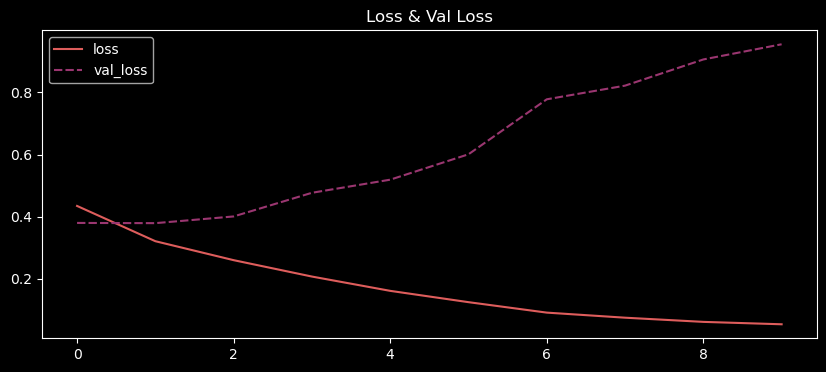

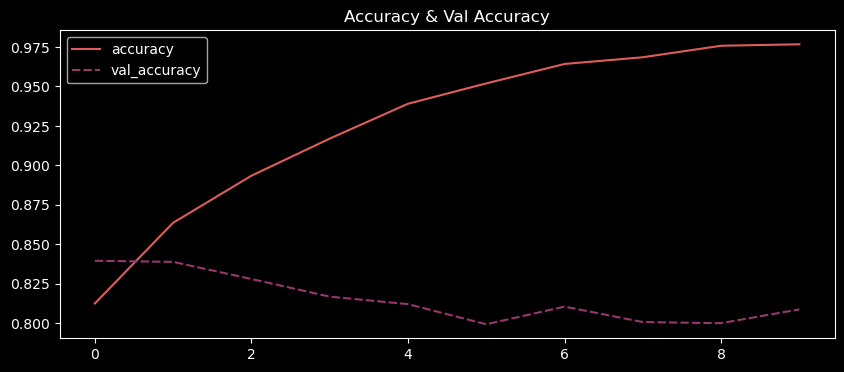

In [65]:
plt.figure(figsize=(10, 4))
plt.title("Loss & Val Loss")
sns.lineplot(df_loss,palette="flare");

plt.figure(figsize=(10, 4))
plt.title("Accuracy & Val Accuracy")
sns.lineplot(df_acc,palette="flare");

179/179 [==============================] - 2s 5ms/step


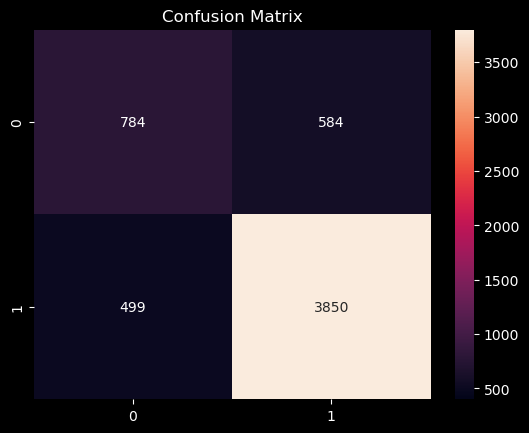

In [66]:
threshold = 0.5
y_pred = (model.predict(X_test) > threshold).astype("int32")
cnf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(cnf_matrix,annot=True,cmap="rocket",fmt=".5g",vmin=400,vmax=3800)
plt.title("Confusion Matrix");